In [121]:
import os

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
import tensorflow as tf

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))   

In [124]:
#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv


#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock


#Attention U-NET
def attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    

In [130]:
filters = [16, 32, 64, 128, 256]
kernelsize = 3
upsample_size = 2
input_shape = (512,512,1)
inputs = layers.Input(input_shape) 

inputs = layers.Input(input_shape) 

# Downsampling layers    
dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

# Upsampling layers    
gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
att_5 = attention_block(dn_4, gating_5, filters[3])
up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
#up_5 = layers.concatenate([up_5, att_5], axis=3)
#up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)

In [141]:
dn_4, gating_5, att_5

(<KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'activation_326')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'activation_329')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'batch_normalization_300')>)

In [132]:
gating_5 -> att_5
dn_4 -> att_5
dn_5 -> up_5

<KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'activation_329')>

In [126]:
x = att_5
gating = gating_5
inter_shape = filters[3]

shape_x = K.int_shape(x)
shape_g = K.int_shape(gating)
theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 

shape_theta_x = K.int_shape(theta_x)
phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
concat_xg = layers.add([upsample_g, theta_x])
act_xg = layers.Activation('relu')(concat_xg)
psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
sigmoid_xg = layers.Activation('sigmoid')(psi)
shape_sigmoid = K.int_shape(sigmoid_xg)
upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          

y = layers.multiply([upsample_psi, x])
result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
attenblock = layers.BatchNormalization()(result)

In [127]:
x, theta_x , phi_g, upsample_g, concat_xg, act_xg, psi, upsample_psi, y, result, attenblock

(<KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'batch_normalization_287')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'conv2d_254')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'conv2d_255')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'conv2d_transpose_28')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'add_28')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'activation_317')>,
 <KerasTensor: shape=(None, 32, 32, 1) dtype=float32 (created by layer 'conv2d_256')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'lambda_20')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'multiply_19')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'conv2d_257')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'batch_normalizat

In [96]:
dn_5

<KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'activation_174')>

In [ ]:
512  512  16
256  256  32
128  128  64
64   64   128
32   32   256
32   32   128
32   32   1

In [50]:
attentionunet((512,512,1), dropout=0.2, batchnorm=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 512, 512, 16  160         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_105 (Batch  (None, 512, 512, 16  64         ['conv2d_39[0][0]']              
 Normalization)                 )                                                           

In [144]:
# Convert all layers to 1D version
def conv_block_1d(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv1D(filters, kernelsize, kernel_initializer='he_normal', padding="same")(x)
    if batchnorm:
        conv = layers.BatchNormalization(axis=2)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv1D(filters, kernelsize, kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm:
        conv = layers.BatchNormalization(axis=2)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

def gatingsignal_1d(input, out_size, batchnorm=False):
    x = layers.Conv1D(out_size, 1, padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block_1d(x, gating, inter_shape):
    theta_x = layers.Conv1D(inter_shape, 1, kernel_initializer='he_normal', padding='same')(x)
    phi_g = layers.Conv1D(inter_shape, 1, kernel_initializer='he_normal', padding='same')(gating)
    
    # Here, calculate the size for upsample to match the shape of theta_x
    size = int(theta_x.shape[1] / phi_g.shape[1])
    upsample_g = layers.UpSampling1D(size=size)(phi_g)
    
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv1D(1, 1, kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_x = x.shape
    mul_xg = layers.Multiply()([sigmoid_xg, x])
    res_xg = layers.Reshape((shape_x[1], shape_x[2]))(mul_xg)
    return res_xg

def attentionunet_1d(input_shape, dropout=0.2, batchnorm=True):
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3

    inputs = layers.Input(input_shape) 

    dn_1 = conv_block_1d(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling1D(pool_size=2)(dn_1)
    
    dn_2 = conv_block_1d(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling1D(pool_size=2)(dn_2)
    
    dn_3 = conv_block_1d(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling1D(pool_size=2)(dn_3)
    
    dn_4 = conv_block_1d(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling1D(pool_size=2)(dn_4)
    
    dn_5 = conv_block_1d(pool_4, kernelsize, filters[4], dropout, batchnorm)
    
    gating_5 = gatingsignal_1d(dn_5, filters[3], batchnorm)
    att_5 = attention_block_1d(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling1D(size=2)(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=2)
    up_conv_5 = conv_block_1d(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal_1d(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block_1d(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling1D(size=2)(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=2)
    up_conv_4 = conv_block_1d(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal_1d(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block_1d(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling1D(size=2)(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=2)
    up_conv_3 = conv_block_1d(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal_1d(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block_1d(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling1D(size=2)(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=2)
    up_conv_2 = conv_block_1d(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv1D(1, kernel_size=1)(up_conv_2)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    

# Toy data
input_shape = (1200, 1)
n_samples = 100
X_train = np.random.rand(n_samples, *input_shape)
y_train = np.random.randint(2, size=(n_samples, *input_shape))

# Instantiate and compile the model
model = attentionunet_1d(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 1200, 1)]    0           []                               
                                                                                                  
 conv1d_162 (Conv1D)            (None, 1200, 16)     64          ['input_42[0][0]']               
                                                                                                  
 batch_normalization_323 (Batch  (None, 1200, 16)    64          ['conv1d_162[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_354 (Activation)    (None, 1200, 16)     0           ['batch_normalization_323[0

KeyboardInterrupt: 

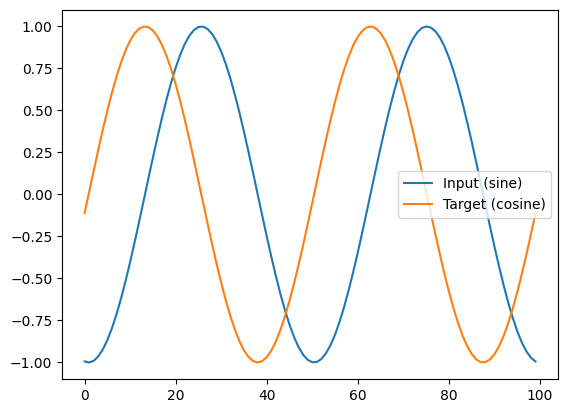

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples=1000, sequence_length=100):
    X = np.zeros((num_samples, sequence_length, 1))
    Y = np.zeros((num_samples, sequence_length, 1))
    
    for i in range(num_samples):
        rand_offset = np.random.randint(0, sequence_length)
        X[i, :, 0] = np.sin(np.linspace(0, 4 * np.pi, sequence_length) + rand_offset)
        Y[i, :, 0] = np.cos(np.linspace(0, 4 * np.pi, sequence_length) + rand_offset)
        
    return X, Y

X, Y = generate_data()

# Let's visualize the first sample for sanity check
plt.plot(X[0], label='Input (sine)')
plt.plot(Y[0], label='Target (cosine)')
plt.legend()
plt.show()


In [118]:
input_shape = (1200, 1)
dropout = 0.2
batchnorm = True

filters = [16, 32, 64, 128, 256]
kernelsize = 3

inputs = layers.Input(input_shape)

# Downsampling layers
dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
pool_1 = layers.MaxPooling1D(pool_size=2)(dn_1)

dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
pool_2 = layers.MaxPooling1D(pool_size=2)(dn_2)

dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
pool_3 = layers.MaxPooling1D(pool_size=2)(dn_3)

dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
pool_4 = layers.MaxPooling1D(pool_size=2)(dn_4)

dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)


# Upsampling layers
gating_5 = gatingsignal(dn_5, filters[3], batchnorm)

In [24]:
dn_1, dn_2, dn_3, dn_4, dn_5

(<KerasTensor: shape=(None, 1000, 16) dtype=float32 (created by layer 'activation_52')>,
 <KerasTensor: shape=(None, 500, 32) dtype=float32 (created by layer 'activation_54')>,
 <KerasTensor: shape=(None, 250, 64) dtype=float32 (created by layer 'activation_56')>,
 <KerasTensor: shape=(None, 125, 128) dtype=float32 (created by layer 'activation_58')>,
 <KerasTensor: shape=(None, 62, 256) dtype=float32 (created by layer 'activation_60')>)

In [32]:
x = dn_5
inter_shape = filters[3]
gating = gating_5

theta_x = layers.Conv1D(inter_shape, 2, strides=2, kernel_initializer='he_normal', padding='same')(x)
phi_g = layers.Conv1D(inter_shape, 1, kernel_initializer='he_normal', padding='same')(gating)

In [39]:
theta_x, phi_g

(<KerasTensor: shape=(None, 31, 128) dtype=float32 (created by layer 'conv1d_34')>,
 <KerasTensor: shape=(None, 62, 128) dtype=float32 (created by layer 'conv1d_35')>)

In [35]:
upsample_g = layers.UpSampling1D(size=2)(phi_g)

In [ ]:
def attention_block(x, gating, inter_shape):

    theta_x = layers.Conv1D(inter_shape, 2, strides=2, kernel_initializer='he_normal', padding='same')(x)
    phi_g = layers.Conv1D(inter_shape, 1, kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.UpSampling1D(size=2)(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv1D(1, 1, kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    upsample_psi = layers.UpSampling1D(size=2)(sigmoid_xg)
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv1D(inter_shape, 1, kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)

In [119]:
# Define the model using the provided function
model = attentionunet(input_shape=(1200, 1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the generated sine/cosine data
history = model.fit(X, Y, epochs=10, batch_size=32, validation_split=0.1)

ValueError: Inputs have incompatible shapes. Received shapes (150, 128) and (75, 128)

In [ ]:
2000 1000 500 250 125

In [ ]:
1200 600 300 150 75